# Подготовка

## Загрузка данных

In [1]:
from typing import Tuple
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

train_data = pd.read_csv("train.csv")
train_data = train_data.convert_dtypes().set_index("Id")
train_data.Price.mean(), \
train_data.loc[train_data.Ecology_2 == 'A'].Price.mean(), \
train_data.loc[train_data.Ecology_2 == 'B'].Price.mean()

(214138.8573987384, 193139.71700581792, 214344.54422274255)

## Первичная обработка

In [2]:
train_data = pd.get_dummies(train_data, columns=["Ecology_2", "Shops_2", "Ecology_3"])
y_train = pd.DataFrame(train_data["Price"])
X_train = train_data.drop('Price', 1)
X_train["LifeSquare"].isnull().value_counts()
X_train.Healthcare_1 = X_train.Healthcare_1.astype(float)
X_train.Rooms = X_train.Rooms.astype(int)

## Замена нулевых значений

In [3]:
import numpy as np


def fill_na(df: pd.DataFrame, column: str, exclude: Tuple[str]) -> pd.DataFrame:
    """
    
    """
    local_df = df.copy()
    local_df.drop([*exclude], 1, inplace=True)
    train_df = local_df[local_df.notnull().all(axis=1)]
    x_train = train_df.drop(column, 1)
    x_predict = local_df.drop(column, 1)[local_df.isnull().any(axis=1)]
    y_train = train_df[column]
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    y_predict = lr.predict(x_predict)
    local2_df = df.copy()
    j=0

    for i in local2_df.loc[local_df.isnull().any(axis=1)].index:
        local2_df.loc[i, column] = y_predict[j].astype(int)
        j += 1
    a = local2_df
    return a


X_train = fill_na(X_train, "Healthcare_1", ("LifeSquare",))
X_train.HouseYear[X_train.HouseYear>2021] = np.nan
X_train = fill_na(X_train, "HouseYear", ("LifeSquare",))
X_train.LifeSquare[X_train.LifeSquare>X_train.Square] = np.nan
X_train.LifeSquare[X_train.LifeSquare<0] = np.nan
X_train = fill_na(X_train, "LifeSquare", ("Healthcare_1",))
X_train.KitchenSquare[(X_train.KitchenSquare>X_train.Square-X_train.LifeSquare)] = np.nan
X_train.KitchenSquare[X_train.KitchenSquare<0] = np.nan
X_train = fill_na(X_train, "KitchenSquare", ("Healthcare_1",))
X_train.HouseFloor[X_train.HouseFloor>50] = np.nan
X_train = fill_na(X_train, "HouseFloor", ("Healthcare_1",))
X_train.Rooms[X_train.Rooms == 0] = 2
X_train.Rooms[X_train.Rooms>8] = np.nan
X_train = fill_na(X_train, "Rooms", ("Healthcare_1",))

# Немного исследования


Во первых стоит посмотреть зависимости разных переменных друг от друга. Немного графиков:

## Зависимость цены от возраста здания

<AxesSubplot:xlabel='Square', ylabel='HouseYear'>

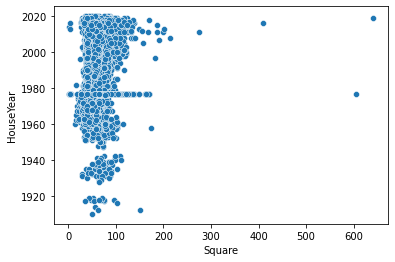

In [4]:
sns.scatterplot(x=X_train.Square, y=X_train.HouseYear)

## Зависимость цены от жилой площади 

<AxesSubplot:xlabel='LifeSquare', ylabel='Price'>

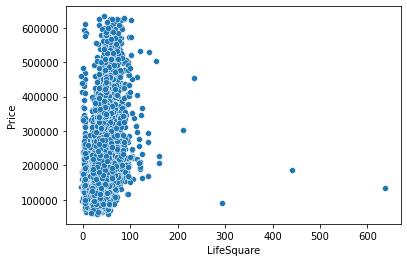

In [5]:
sns.scatterplot(x=X_train.LifeSquare, y=train_data.Price)

## Зависимость цены от общей площади

<AxesSubplot:xlabel='Square', ylabel='Price'>

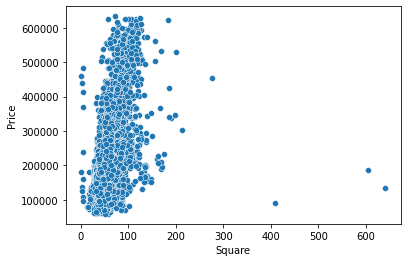

In [6]:
sns.scatterplot(x=X_train.Square, y=train_data.Price)

## Зависимость цены от состояния экологии

<AxesSubplot:xlabel='Ecology_1', ylabel='Price'>

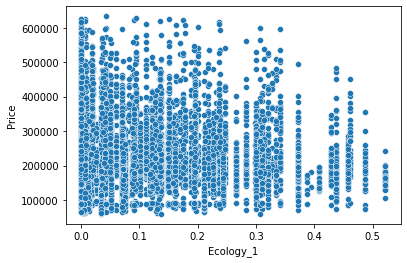

In [7]:
sns.scatterplot(x=X_train.Ecology_1, y=train_data.Price)

## Зависимость цены от количества комнат

<AxesSubplot:xlabel='Rooms', ylabel='Price'>

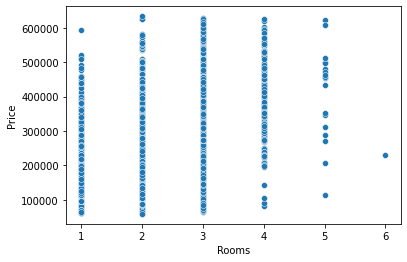

In [8]:
sns.scatterplot(x=X_train.Rooms, y=train_data.Price)

## Зависимость цены от этажа квартиры

<AxesSubplot:xlabel='Floor', ylabel='Price'>

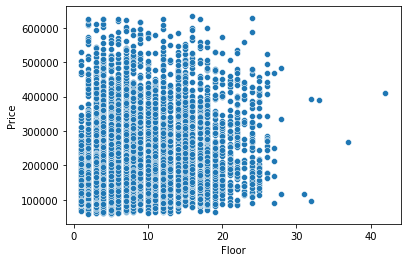

In [9]:
sns.scatterplot(x=X_train.Floor, y=train_data.Price)

## Зависимость цены от количства этажей в доме

<AxesSubplot:xlabel='HouseFloor', ylabel='Price'>

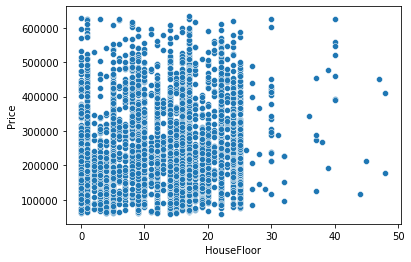

In [10]:
sns.scatterplot(x=X_train.HouseFloor, y=train_data.Price)

## Зависимости цены от Social

<AxesSubplot:xlabel='Social_1', ylabel='Price'>

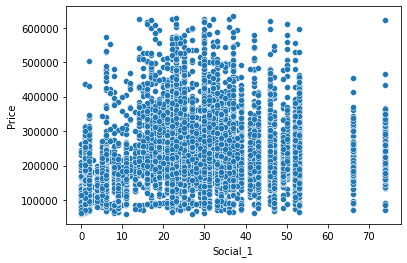

In [11]:
sns.scatterplot(x=X_train.Social_1, y=train_data.Price)

<AxesSubplot:xlabel='Social_2', ylabel='Price'>

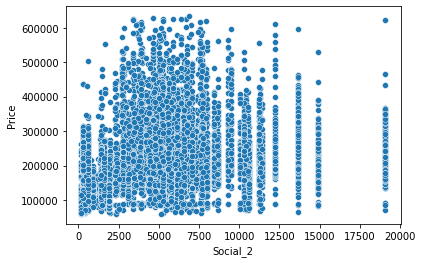

In [12]:
sns.scatterplot(x=X_train.Social_2, y=train_data.Price)

<AxesSubplot:xlabel='Social_3', ylabel='Price'>

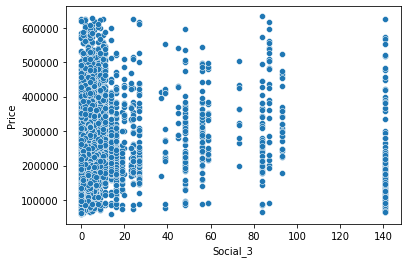

In [13]:
sns.scatterplot(x=X_train.Social_3, y=train_data.Price)

<AxesSubplot:xlabel='Healthcare_1', ylabel='Price'>

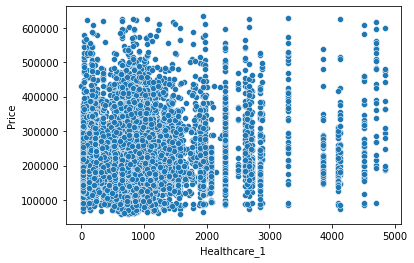

In [14]:
sns.scatterplot(x=X_train.Healthcare_1, y=train_data.Price)

<AxesSubplot:xlabel='Shops_1', ylabel='Price'>

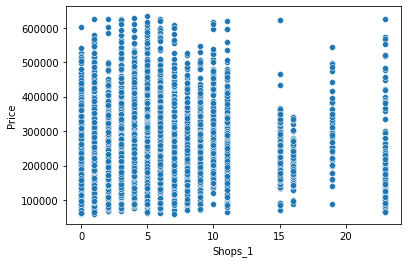

In [15]:
sns.scatterplot(x=X_train.Shops_1, y=train_data.Price)

<AxesSubplot:xlabel='KitchenSquare', ylabel='Price'>

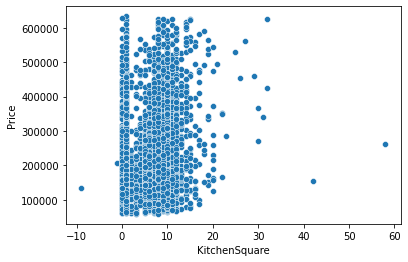

In [16]:
sns.scatterplot(x=X_train.KitchenSquare, y=train_data.Price)

# Построение модели

In [17]:
X_train

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Shops_2_A,Shops_2_B,Ecology_3_A,Ecology_3_B
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6,7,9,1969,0.08904,33,...,5,608.0,0,11,0,1,0,1,0,1
15053,41,3.0,65.68364,40.049543,8,7,9,1978,0.00007,46,...,1,240.0,1,16,0,1,0,1,0,1
4765,53,2.0,44.947953,29.197612,0,8,12,1968,0.049637,34,...,0,229.0,1,3,0,1,0,1,0,1
5809,58,2.0,53.352981,52.731512,3,8,17,1977,0.437885,23,...,3,1084.0,0,5,0,1,0,1,0,1
10783,99,1.0,39.649192,23.776169,7,11,12,1976,0.012339,35,...,1,2078.0,2,4,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,2.0,50.401785,30.476203,5,6,5,1968,0.13565,46,...,6,350.0,3,11,0,1,0,1,0,1
6159,18,1.0,41.521546,20.539216,9,13,13,2000,0.0,30,...,0,505.0,0,5,0,1,1,0,0,1
5123,27,1.0,47.939008,28.0,1,12,16,2015,0.072158,2,...,1,660.0,0,0,0,1,1,0,0,1


# Чистка данных

In [18]:
columns_drop = ['Social_3', 'Ecology_3_A', 'Shops_2_B']
X_train.drop(columns_drop, 1, inplace=True)
X_train['HouseYear'] = 2021 - X_train['HouseYear']
X_train['SquarePerRoom'] = X_train['Square'] / X_train['Rooms']
X_train

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Shops_2_A,Ecology_3_B,SquarePerRoom
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6,7,9,52,0.08904,33,7976,608.0,0,11,0,1,0,1,23.990781
15053,41,3.0,65.68364,40.049543,8,7,9,43,0.00007,46,10309,240.0,1,16,0,1,0,1,21.894547
4765,53,2.0,44.947953,29.197612,0,8,12,53,0.049637,34,7759,229.0,1,3,0,1,0,1,22.473976
5809,58,2.0,53.352981,52.731512,3,8,17,44,0.437885,23,5735,1084.0,0,5,0,1,0,1,26.676491
10783,99,1.0,39.649192,23.776169,7,11,12,45,0.012339,35,5776,2078.0,2,4,0,1,0,1,39.649192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,2.0,50.401785,30.476203,5,6,5,53,0.13565,46,7960,350.0,3,11,0,1,0,1,25.200892
6159,18,1.0,41.521546,20.539216,9,13,13,21,0.0,30,5562,505.0,0,5,0,1,1,1,41.521546
5123,27,1.0,47.939008,28.0,1,12,16,6,0.072158,2,629,660.0,0,0,0,1,1,1,47.939008


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_columns = X_train.columns
X_train = scaler.fit_transform(X_train)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)

In [20]:
X_train = pd.DataFrame(X_train, columns = X_train_columns)
X_train

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Shops_2_A,Ecology_3_B,SquarePerRoom
0,0.449761,0.4,0.094505,0.065458,0.253731,0.073171,0.291667,0.245455,1.000000,0.337838,0.316204,0.320685,0.000000,0.000000,0.0,1.0,0.0,1.0,0.047518
1,0.004785,0.2,0.083671,0.063740,0.268657,0.317073,0.354167,0.118182,0.049072,0.445946,0.269257,0.049495,0.500000,0.043478,0.0,1.0,0.0,1.0,0.064179
2,0.272727,0.2,0.095387,0.060412,0.283582,0.292683,0.458333,0.154545,0.173989,1.000000,1.000000,0.195092,0.833333,0.652174,0.0,1.0,0.0,1.0,0.073360
3,0.052632,0.2,0.068470,0.051955,0.223881,0.073171,0.187500,0.390909,0.000325,0.486486,0.307904,0.188286,0.166667,0.043478,0.0,1.0,0.0,1.0,0.052266
4,0.028708,0.0,0.065872,0.049832,0.134328,0.073171,0.354167,0.390909,0.466028,0.067568,0.073804,0.111363,0.000000,0.000000,0.0,1.0,0.0,1.0,0.103244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,0.315789,0.2,0.128719,0.091768,0.298507,0.024390,0.500000,0.072727,0.213900,0.675676,0.638118,0.406269,0.333333,0.130435,0.0,1.0,0.0,1.0,0.099481
7496,0.028708,0.0,0.062943,0.042700,0.238806,0.097561,0.354167,0.390909,0.466028,0.067568,0.073804,0.111363,0.000000,0.000000,0.0,1.0,0.0,1.0,0.098654
7497,0.526316,0.4,0.123501,0.075132,0.313433,0.048780,0.250000,0.100000,0.064181,0.891892,0.550093,0.272634,0.500000,0.347826,0.0,1.0,0.0,1.0,0.062667
7498,0.167464,0.0,0.051639,0.034549,0.208955,0.146341,0.187500,0.390909,0.170618,0.445946,0.412794,0.120025,0.000000,0.478261,0.0,1.0,0.0,1.0,0.080937


In [21]:
clf = RandomForestRegressor(**{'max_depth': 9, 'n_estimators': 10, "random_state": 177})
clf.fit(X_train, y_train.values.ravel())

RandomForestRegressor(max_depth=9, n_estimators=10, random_state=177)

In [22]:
X_test = pd.get_dummies(pd.read_csv('test.csv').convert_dtypes().set_index("Id"), columns=["Ecology_2", "Shops_2", "Ecology_3"])

In [23]:
X_test = fill_na(X_test, "Healthcare_1", ("LifeSquare",))
X_test.LifeSquare[X_test.LifeSquare>X_test.Square] = np.nan
X_test.LifeSquare[X_test.LifeSquare<0] = np.nan
X_test = fill_na(X_test, "LifeSquare", ("Healthcare_1",))
X_test.KitchenSquare[(X_test.KitchenSquare>X_test.Square-X_test.LifeSquare)] = np.nan
X_test.KitchenSquare[X_test.KitchenSquare<0] = np.nan
X_test = fill_na(X_test, "KitchenSquare", ("Healthcare_1",))
X_test.HouseFloor[X_test.HouseFloor>50] = np.nan
X_test = fill_na(X_test, "HouseFloor", ("Healthcare_1",))
X_test.Rooms[X_test.Rooms == 0] = 2
X_test.Rooms[X_test.Rooms>8] = np.nan
X_test = fill_na(X_test, "Rooms", ("Healthcare_1",))

In [24]:
columns_drop = ['Social_3', 'Ecology_3_A', 'Shops_2_B']
X_test.drop(columns_drop, 1, inplace=True)
X_test['HouseYear'] = 2021 - X_test['HouseYear']
X_test['SquarePerRoom'] = X_test['Square'] / X_test['Rooms']
pd.DataFrame(scaler.transform(X_test), columns=X_train_columns)


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Shops_2_A,Ecology_3_B,SquarePerRoom
0,0.277512,0.2,0.076174,0.058292,0.223881,0.121951,0.291667,0.436364,0.594403,0.148649,0.136400,0.250155,0.000000,0.000000,0.0,1.0,0.0,1.0,0.058303
1,0.354067,0.2,0.106459,0.071633,0.149254,0.121951,0.020833,0.390909,0.145207,0.081081,0.067090,0.225407,0.000000,0.086957,0.0,1.0,0.0,1.0,0.082037
2,0.909091,0.0,0.019472,0.021801,0.194030,0.024390,0.104167,1.009091,0.000000,0.405405,0.389638,0.969684,0.833333,0.217391,0.0,1.0,0.0,1.0,0.030520
3,0.224880,0.2,0.112372,0.087113,0.268657,0.512195,0.458333,0.118182,0.195208,0.310811,0.233413,0.164776,0.500000,0.130435,0.0,1.0,0.0,1.0,0.086670
4,0.129187,0.0,0.072493,0.073794,0.149254,0.390244,0.354167,0.027273,0.138268,0.027027,0.024372,0.090328,0.000000,0.000000,0.0,1.0,1.0,1.0,0.113621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.052632,0.4,0.103132,0.085352,0.223881,0.097561,0.187500,0.427273,0.000325,0.486486,0.307904,0.170551,0.166667,0.043478,0.0,1.0,0.0,1.0,0.052025
4996,0.004785,0.0,0.061041,0.040188,0.283582,0.268293,0.354167,0.027273,0.013648,0.013514,0.005075,0.057744,0.000000,0.043478,0.0,1.0,0.0,1.0,0.095672
4997,0.057416,0.4,0.119865,0.081416,0.268657,0.536585,0.458333,0.281818,0.173989,1.000000,1.000000,0.158383,0.833333,0.652174,0.0,1.0,0.0,1.0,0.060767
4998,0.296651,0.2,0.125277,0.080976,0.134328,0.073171,0.000000,0.390909,0.138268,0.027027,0.024372,0.209115,0.000000,0.000000,0.0,1.0,1.0,1.0,0.096784


In [25]:
X_test["Price"] = clf.predict(X_test)

In [26]:
X_test.drop([column for column in X_test.columns if column !="Price"],1,inplace=True)
with open('Vetoshkin_predictions.csv', 'wt') as file:
    file.write(X_test.to_csv())